# Simulation of chirp compression

ver 0.1: July 3, 2018

ver 0.2: Sep 6, 2018

Reference: 
- [Sound Synthesis with Numpy](https://dzone.com/articles/sound-synthesis-numpy)
- [Radar Pulse Compression](https://www.ittc.ku.edu/workshops/Summer2004Lectures/Radar_Pulse_Compression.pdf)

In [36]:
%matplotlib inline
%run ./dsp.py
Fs = 44100

In [37]:
c = Chirp(f0=440, f1=1760, fs=Fs, T=0.02, A=20000)
cl = Chirp(f0=440, f1=1760, fs=Fs, T=2.0, A=20000)

## Up chirp

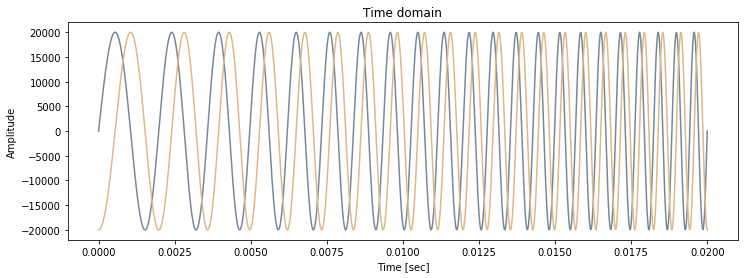

In [38]:
# Upchirp by complex exponential function
plot_wave(Fs, c.chirp())

In [39]:
play(rate=Fs, data=np.real(cl.chirp()))

Frequencies at peaks: [ 462. 1738.] Hz


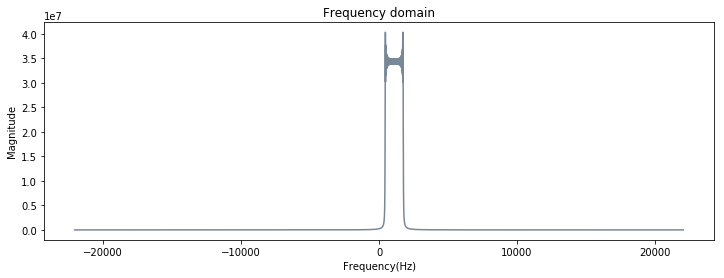

In [40]:
plot_fft(Fs, cl.chirp())

Frequencies at peaks: [-1738.  -462.   462.  1738.] Hz


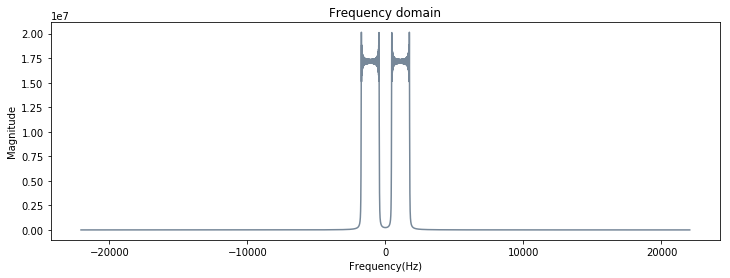

In [41]:
plot_fft(Fs, cl.chirp_cos())

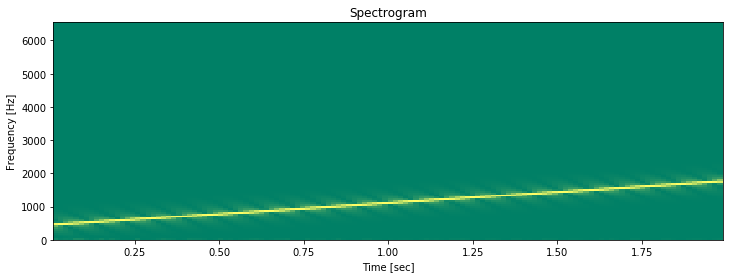

In [42]:
plot_spectrogram(Fs, cl.chirp(), nperseg=256*3, band=0.3, cmap='summer')

## Up chirp * up chirp

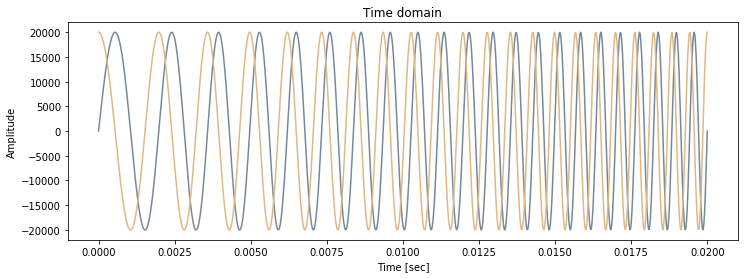

In [43]:
# Up chirp conjugate
plot_wave(Fs, c.chirp().conjugate())

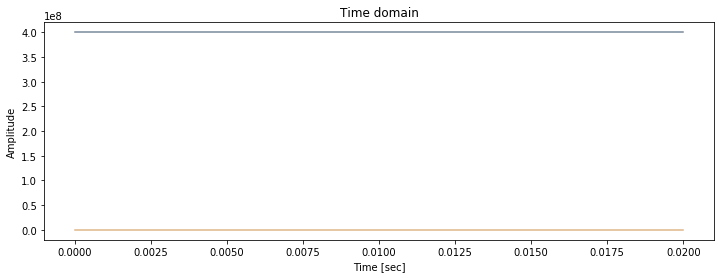

In [44]:
# Up chirp * up chirp conjugate becomes DC
plot_wave(Fs, c.chirp() * c.chirp().conjugate())

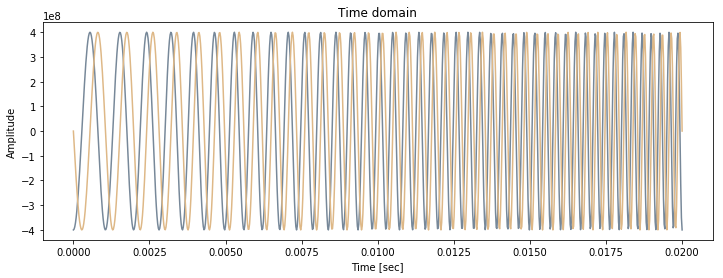

In [45]:
# Up chirp * up chirp becomes chirp with doubled frequency and DC offset
plot_wave(Fs, c.chirp() * c.chirp())

Frequencies at peaks: [0.] Hz


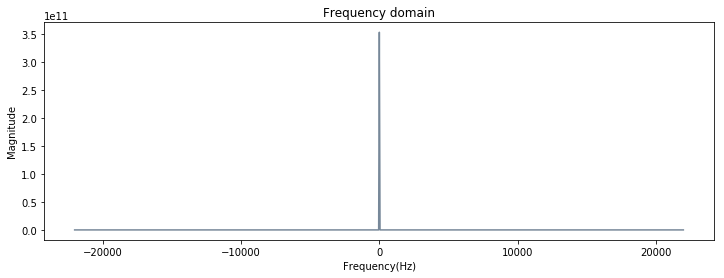

In [46]:
plot_fft(Fs, c.chirp() * c.chirp().conjugate())

Frequencies at peaks: [0.] Hz


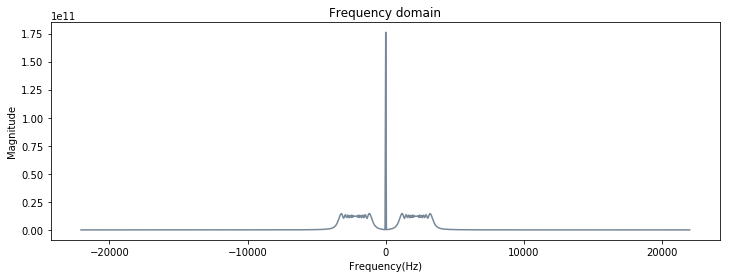

In [47]:
# Chirp squared term
plot_fft(Fs, c.chirp_cos() * c.chirp_cos())

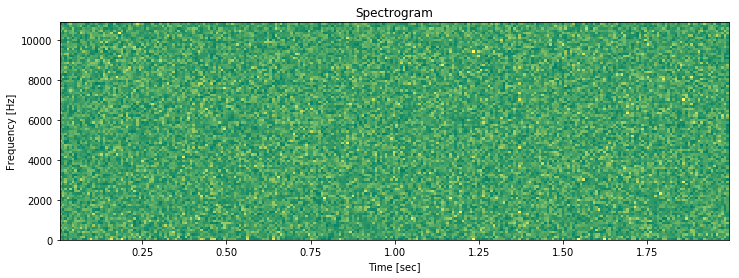

In [48]:
plot_spectrogram(Fs, cl.chirp() * cl.chirp().conjugate(), nperseg=128*3, band=0.5)

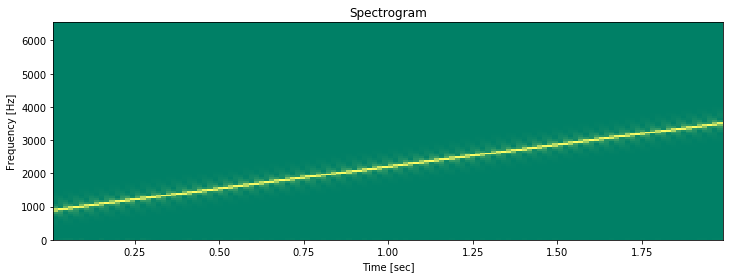

In [49]:
# Chirp squared term
plot_spectrogram(Fs, cl.chirp_cos() * cl.chirp_cos(), nperseg=256*3, band=0.3)

## Up chirp * Down chirp

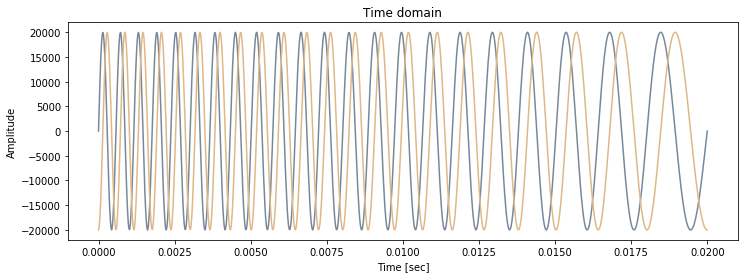

In [50]:
plot_wave(Fs, c.chirp(updown="down"))

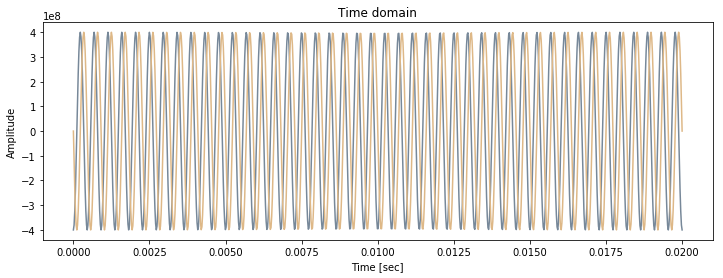

In [51]:
plot_wave(Fs, c.chirp() * c.chirp(updown="down"))

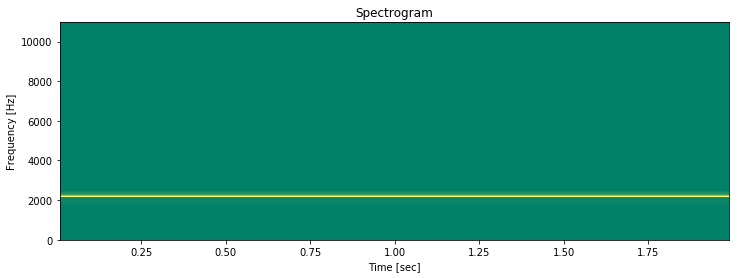

In [52]:
cl = Chirp(f0=440, f1=1760, fs=Fs, T=2.0, A=np.sqrt(20000))
plot_spectrogram(Fs, cl.chirp() * cl.chirp(updown="down"), nperseg=256*3, band=0.5)
play(rate=Fs, data=np.real(cl.chirp() * cl.chirp(updown="down")))

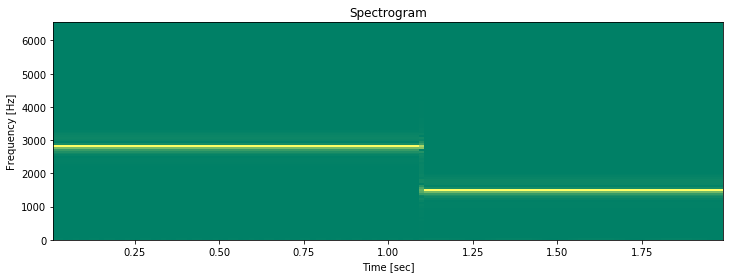

In [55]:
# Unsynchronized upchirp * downchirp
upchirp=cl.chirp()
plot_spectrogram(Fs, np.append(upchirp[40000:], upchirp[:40000]) * cl.chirp(updown="down"),nperseg=256*3,  band=0.3)
play(rate=Fs, data=np.real(np.append(upchirp[40000:], upchirp[:40000]) * cl.chirp(updown="down")))

Frequencies at peaks: [2200.] Hz


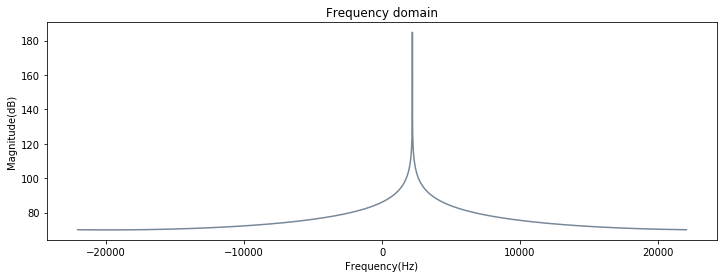

In [57]:
plot_fft(Fs, cl.chirp() * cl.chirp(updown="down"), logscale=True)

## Radar system

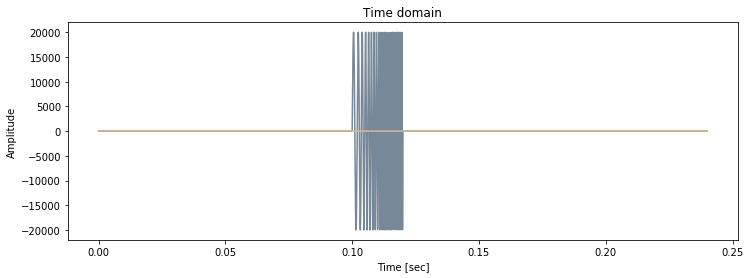

In [58]:
c = Chirp(f0=440, f1=1760, fs=Fs, T=0.02, A=20000)
plot_wave(Fs, add_delay(Fs, c.chirp_cos(), 0.1))

Frequencies at peaks: [0.] Hz


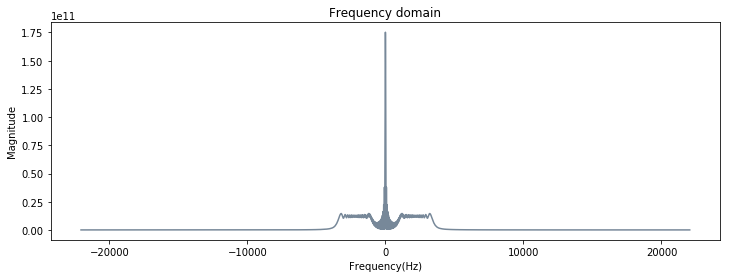

In [59]:
cr = Chirp(f0=440, f1=440+(1760-440)*12, fs=44100, T=0.02*12, A=20000)
plot_fft(Fs, add_delay(Fs, c.chirp_cos(), 0.1, transmitter=True) * cr.chirp_cos())

Frequencies at peaks: [-6600.  6600.] Hz


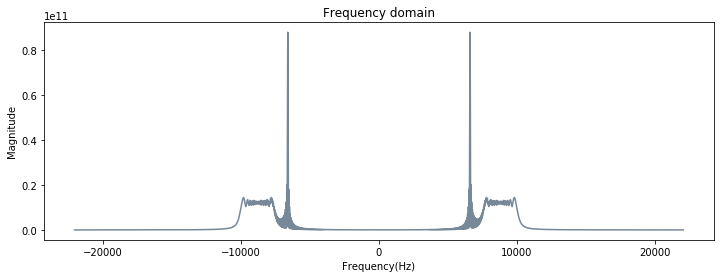

In [60]:
plot_fft(Fs, add_delay(Fs, c.chirp_cos(), 0.1, transmitter=False) * cr.chirp_cos())

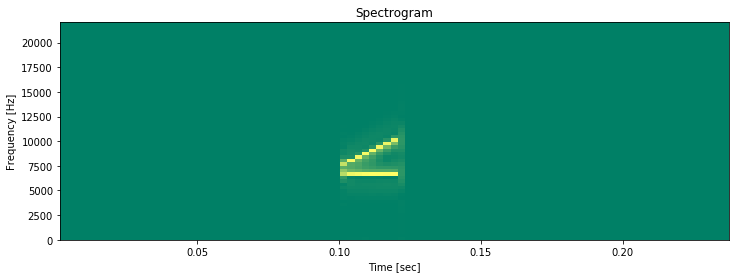

In [61]:
plot_spectrogram(Fs, add_delay(Fs, c.chirp_cos(), 0.1) * cr.chirp_cos(), nperseg=128*1, band=1)

## Compress chirp in frequency domain (chirp signal under noise level)

### Complex chirp signal

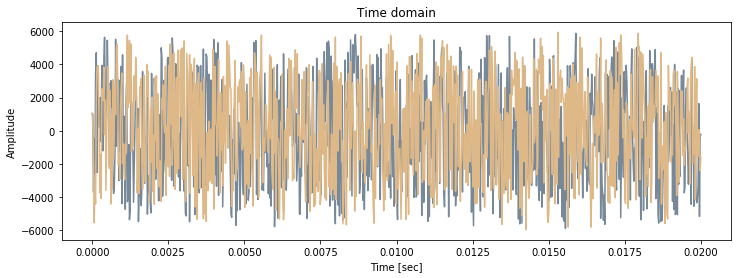

In [62]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 5000)
c = Chirp(f0=440, f1=1760, fs=44100, T=0.02, A=1000)
plot_wave(Fs, c.chirp() + c.white_noise(A=5000))

Frequencies at peaks: [1150. 1600.] Hz


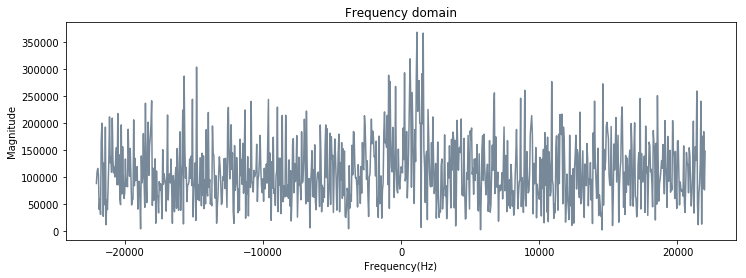

In [63]:
plot_fft(Fs, c.chirp() + c.white_noise(A=5000))

Frequencies at peaks: [0.] Hz


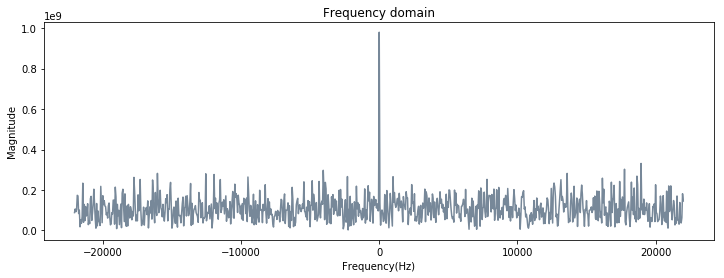

In [64]:
plot_fft(Fs, (c.chirp() + c.white_noise(A=5000)) * c.chirp().conjugate())

# Compress chirp in time domain

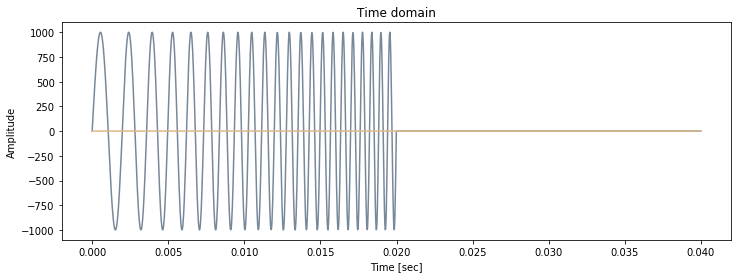

In [65]:
c = Chirp(f0=440, f1=1760, fs=44100, T=0.02, A=1000)
receive_buf = buffer(Fs, 0.02*2, c.chirp_cos())
matched_filter = c.chirp_cos(updown="down", phase=np.pi/2)
plot_wave(Fs, receive_buf)

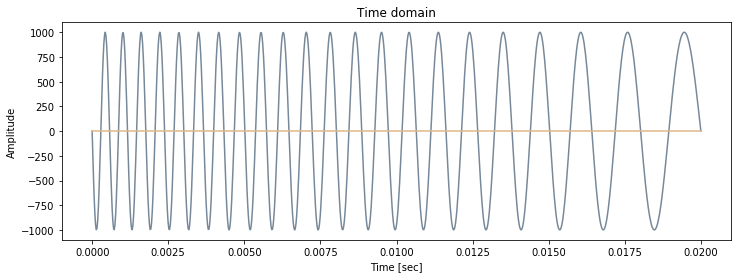

In [66]:
# Matched filter
plot_wave(Fs, matched_filter)

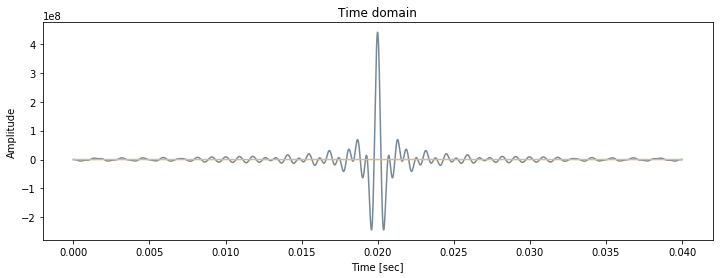

In [67]:
# Chirp compression
plot_wave(Fs, sg.lfilter(matched_filter, 1, receive_buf))

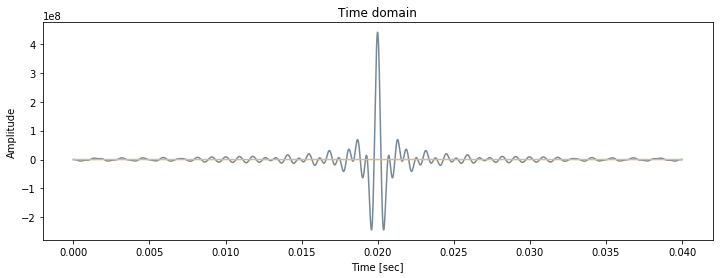

In [68]:
# Same calculation in frequency domain
receive_buf = buffer(Fs, 0.02*2, c.chirp_cos())
matched_filter = c.chirp_cos(updown="down", phase=np.pi/2)
reference_buf = buffer(Fs, 0.02*2, matched_filter)
plot_wave(Fs, ifft(fft(receive_buf) * fft(reference_buf)))

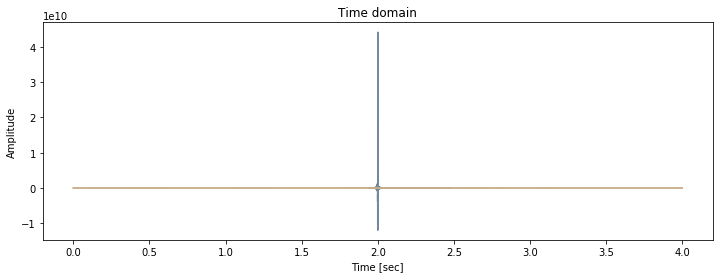

In [69]:
# This takes time
cl = Chirp(f0=440, f1=1760*4, fs=44100, T=2.0, A=1000)
receive_buf = buffer(Fs, 2.0*2, cl.chirp_cos())
matched_filter = cl.chirp_cos(updown="down", phase=np.pi/2)
plot_wave(Fs, sg.lfilter(matched_filter, 1, receive_buf))

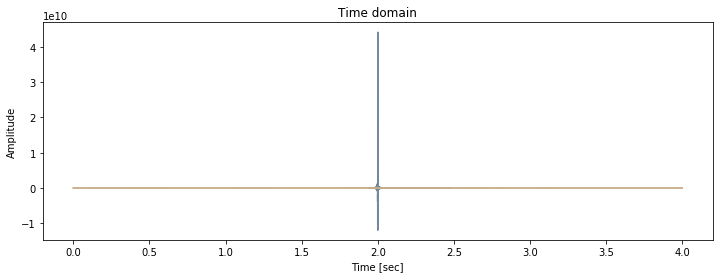

In [70]:
# A lot faster
reference_buf = buffer(Fs, 2.0*2, matched_filter)
plot_wave(Fs, ifft(fft(receive_buf) * fft(reference_buf)))